## Reflectance Spectrum of Air-Silica Interface

We will compute the broadband [reflectance](https://en.wikipedia.org/wiki/Reflectance) spectrum at normal incidence for a planar interface of vacuum/air and [fused quartz](https://en.wikipedia.org/wiki/Fused_quartz). As a validation, we will compare the simulated result with the analytic reflectance computed using the [Fresnel equations](https://en.wikipedia.org/wiki/Fresnel_equations). This is similar to an example in [Tutorial/Basics/Angular Reflectance Spectrum of a Planar Interface](https://meep.readthedocs.io/en/latest/Python_Tutorials/Basics/#angular-reflectance-spectrum-of-a-planar-interface) which involved computing the broadband reflectance spectrum over a range of angles.

The wavelength-dependent, lossless permittivity of fused quartz, measured experimentally at 20°C, can be approximated by the [Sellmeier equation](https://en.wikipedia.org/wiki/Sellmeier_equation):

$$\varepsilon(\lambda) = 1 + \frac{0.6961663\lambda^2}{\lambda^2-0.0684043^2} + \frac{0.4079426\lambda^2}{\lambda^2-0.1162414^2} + \frac{0.8974794\lambda^2}{\lambda^2-9.896161^2}$$

The wavelength λ is in units of microns. This equation is valid from 0.21 to 6.7 μm. The Sellmeier form for the permittivity of fused quartz can be imported into Meep as a [Lorentzian susceptibility](https://meep.readthedocs.io/en/latest/Materials/#material-dispersion) via a slight reorganization to convert the wavelength dependence into frequency as described in [Materials](https://meep.readthedocs.io/en/latest/Materials/#sellmeier-coefficients). This is implemented in the [materials library](https://github.com/NanoComp/meep/blob/master/python/materials.py#L153-L173).

The simulation involves a 1d cell. A planewave current source with a pulsed profile spanning visible wavelengths of 0.4 to 0.8 μm is normally incident on the fused quartz from air. The reflectance is computed using the convention of two separate runs: (1) an empty cell to obtain the incident power, and (2) with the fused quartz to obtain the reflected power. The details of this type of calculation are described in [Tutorial/Basics/Transmittance Spectrum of a Waveguide Bend](https://meep.readthedocs.io/en/latest/Python_Tutorials/Basics/#transmittance-spectrum-of-a-waveguide-bend). The grid resolution, and by direct extension the time resolution via the [Courant condition](https://en.wikipedia.org/wiki/Courant%E2%80%93Friedrichs%E2%80%93Lewy_condition), must be made sufficiently fine to obtain agreement with the analytic results and to ensure [numerical stability](https://meep.readthedocs.io/en/latest/Materials/#numerical-stability). Coarse resolutions may lead to field instabilities.

In [1]:
import meep as mp
from meep.materials import fused_quartz
import numpy as np
import math
import matplotlib.pyplot as plt

resolution = 200  # pixels/μm

dpml = 1.0
sz = 10 + 2 * dpml
cell_size = mp.Vector3(z=sz)
pml_layers = [mp.PML(dpml)]

wvl_min = 0.4
wvl_max = 0.8
fmin = 1 / wvl_max
fmax = 1 / wvl_min
fcen = 0.5 * (fmax + fmin)
df = fmax - fmin
nfreq = 50

sources = [
    mp.Source(
        mp.GaussianSource(fcen, fwidth=df),
        component=mp.Ex,
        center=mp.Vector3(z=-0.5 * sz + dpml),
    )
]

sim = mp.Simulation(
    cell_size=cell_size,
    boundary_layers=pml_layers,
    sources=sources,
    dimensions=1,
    resolution=resolution,
)

refl_fr = mp.FluxRegion(center=mp.Vector3(z=-0.25 * sz))
refl = sim.add_flux(fcen, df, nfreq, refl_fr)

sim.run(until_after_sources=mp.stop_when_fields_decayed(50, mp.Ex, mp.Vector3(), 1e-9))

empty_flux = mp.get_fluxes(refl)
empty_data = sim.get_flux_data(refl)
sim.reset_meep()

geometry = [
    mp.Block(
        mp.Vector3(mp.inf, mp.inf, 0.5 * sz),
        center=mp.Vector3(z=0.25 * sz),
        material=fused_quartz,
    )
]

sim = mp.Simulation(
    cell_size=cell_size,
    boundary_layers=pml_layers,
    geometry=geometry,
    sources=sources,
    dimensions=1,
    resolution=resolution,
)

refl = sim.add_flux(fcen, df, nfreq, refl_fr)
sim.load_minus_flux_data(refl, empty_data)

sim.run(until_after_sources=mp.stop_when_fields_decayed(50, mp.Ex, mp.Vector3(), 1e-9))

refl_flux = mp.get_fluxes(refl)
R_meep = -1 * np.divide(refl_flux, empty_flux)

-----------
Initializing structure...
time for choose_chunkdivision = 0.000452042 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 12 with resolution 200
time for set_epsilon = 0.00140619 s
-----------
field decay(t = 50.0025): 0.25018932773921454 / 0.25018932773921454 = 1.0
on time step 32117 (time=80.2925), 0.000124548 s/step
field decay(t = 100.0025): 4.358317201613301e-16 / 0.25018932773921454 = 1.742007639173244e-15
run 0 finished at t = 100.0025 (40001 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.00031209 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 12 with resolution 200
     block, center = (0,0,3)
          size (1e+20,1e+20,6)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.00108504 s
lorentzian susceptibility: frequency=0.101049, gamma=0
lorentzian susceptibility: frequency=8.60279, gamma=0
lorentzian susceptibility: frequency=14.619, gamma=0

A plot of the reflectance spectrum based on the simulated data and the analytic Fresnel equation is generated and shown below. There is agreement between the simulated and analytic results. Note that the reflectance spectra is plotted as a function of wavelength, not frequency from which the Meep data is obtained. Thus, the data points are not equally spaced: the spacing is smaller at low wavelengths (high frequencies) than at high wavelengths (low frequencies).

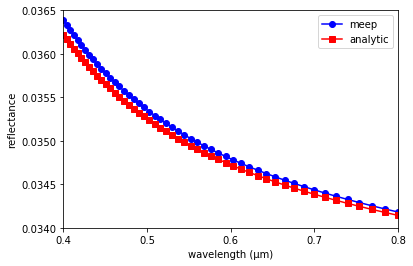

In [2]:
freqs = mp.get_flux_freqs(refl)
wvls = np.divide(1, freqs)

eps_quartz = (
    lambda l: 1
    + 0.6961663 * math.pow(l, 2) / (pow(l, 2) - pow(0.0684043, 2))
    + 0.4079426 * pow(l, 2) / (pow(l, 2) - pow(0.1162414, 2))
    + 0.8974794 * pow(l, 2) / (pow(l, 2) - pow(9.896161, 2))
)
R_fresnel = lambda l: math.pow(
    math.fabs(1 - math.sqrt(eps_quartz(l))) / (1 + math.sqrt(eps_quartz(l))), 2
)
R_analytic = [R_fresnel(i) for i in wvls]

plt.figure()
plt.plot(wvls, R_meep, "bo-", label="meep")
plt.plot(wvls, R_analytic, "rs-", label="analytic")
plt.xlabel("wavelength (μm)")
plt.ylabel("reflectance")
plt.axis([0.4, 0.8, 0.0340, 0.0365])
plt.xticks([t for t in np.arange(0.4, 0.9, 0.1)])
plt.legend(loc="upper right")
plt.show()